# Create ACS Index and Azure SQL Database for Avatar Demo
Use this notebook to create an Azure Cognitive Search Index and an Azure SQL Database and populate demo content for the Avatar outdoor shop application.  

Ensure that you have the the Microsoft ODBC driver for SQL Server installed. Here are the instructions for Linux based systems:  
https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/installing-the-microsoft-odbc-driver-for-sql-server?view=sql-server-ver16&tabs=ubuntu18-install%2Calpine17-install%2Cdebian8-install%2Credhat7-13-install%2Crhel7-offline#18


## Setup

In [1]:
# Install the required libraries
%pip install azure-search-documents==11.4.0b6 openai==0.28.1 tenacity pyodbc

# Install library for Azure Authentication
%pip install azure-identity azure-storage-blob

  Using cached azure_search_documents-11.4.0b6-py3-none-any.whl.metadata (22 kB)
  Using cached openai-0.28.1-py3-none-any.whl.metadata (11 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached propcache-0.3.1-cp312-cp312-win_amd64.whl.metadata (11 kB)
Using cached azure_search_documents-11.4.0b6-py3-none-any.whl (306 kB)
Using cached openai-0.28.1-py3-none-any.whl (76 kB)
Using cached tenacity-9.1.2-py3-none-any.whl (28 kB)
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.3.2-py2.py3-none-any.whl (7.6 kB)
Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
Using cached propcache-0.3.1-cp312-cp312-win_amd64.whl (44 kB)
Using cached tqdm-4.67.1-py3-none-any.whl

In [2]:
%pip install pandas


  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.6 MB 8.5 MB/s eta 0:00:02
   ---------- ----------------------------- 3.4/12.6 MB 11.2 MB/s eta 0:00:01
   ------------------- -------------------- 6.0/12.6 MB 11.9 MB/s eta 0:00:01
   --------------------- ------------------ 6.8/12.6 MB 12.0 MB/s eta 0:00:01
   ----------------------------- ---------- 9.2/12.6 MB 10.0 MB/s eta 0:00:01
   ------------------------------------ --- 11.5/12.6 MB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 9.6 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   --

In [1]:
import os
import json  
import pandas as pd

import pyodbc
import requests
import inspect

import openai  
from tenacity import retry, wait_random_exponential, stop_after_attempt  
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import Vector  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    SemanticConfiguration,  
    PrioritizedFields,  
    SemanticField,  
    SearchField,  
    SemanticSettings,  
    VectorSearch,  
    VectorSearchAlgorithmConfiguration,  
)  

You need to have the following settings for your Azure resources defined in the `local.settings.json` file in the __api__ subfolder to populate the demo content for the outdoor app:

In [2]:
#%pwd
#!cd c:/users/chihengchou/downloads/work/work/gen-cv-forked/gen-cv/avatar/interactive
%cd c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv\\avatar\\interactive
%pwd

c:\Users\chihengchou\Downloads\work\work\gen-cv\avatar\interactive


'c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv\\avatar\\interactive'

In [3]:
# Load JSON file
with open('./api/local.settings.json', 'r') as file:
    data = json.load(file)

# Azure Cognitive Search
service_endpoint = data["Values"]["AZURE_SEARCH_ENDPOINT"]
key = data["Values"]["AZURE_SEARCH_API_KEY"]
index_name = data["Values"]["AZURE_SEARCH_INDEX"]

# Azure OpenAI
openai.api_type = "azure"
openai.api_key = data["Values"]["AZURE_OPENAI_API_KEY"]
openai.api_base = data["Values"]["AZURE_OPENAI_ENDPOINT"]
openai.api_version = data["Values"]["AZURE_OPENAI_API_VERSION"]
AOAI_embeddings_deployment = data["Values"]["AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT"]


## Create Cognitive Search Index
First, we create a new Index with demo data to the Cognitive Search service that you have deployed manually.

In [34]:
credential = AzureKeyCredential(key)

# csv原始資料需要去掉/n
df = pd.read_csv('data/products_cs_index.csv', dtype={'id': str})

#display(df.head())
display(df.tail())
input_data = df.to_dict(orient='records')

,id,content,product_image_file
3,4,'微軟成立於1975年，總部位於美國華盛頓州雷德蒙德市，是全球最大軟體公司之一',microsoft.png
4,5,'泰瑞達股份有限公司（Teradyne Robotics）擁有全球最大的 Universal...,mir.png
5,6,'2025 AI Workshop # 目的與願景: 透過主題演講 案例分享 成果展示 廠商...,ai-workshop.png
6,7,'微軟的核心產品: - Windows 作業系統- Microsoft Office 辦公軟...,microsoft.png
7,8,'本次微軟展示的內容包含了以下幾種最新的AI應用 # M365 Copilot 應用示範 –...,microsoft.png


In [35]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
# Function to generate embeddings for title and content fields, also used for query embeddings
def generate_embeddings(text):
    response = openai.Embedding.create(
        input=text, engine=AOAI_embeddings_deployment)
    embeddings = response['data'][0]['embedding']
    return embeddings

In [36]:
# Generate embeddings for title and content fields
for item in input_data:
    content = item['content']
    content_embeddings = generate_embeddings(content)
    item['content_vector'] = content_embeddings

In [37]:
# Output embeddings to docVectors.json file
with open("./data/product-catalog-vectors.json", "w") as f:
    json.dump(input_data, f)

In [38]:
# Delete ACS index if it exists
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

try:
    if index_client.get_index(index_name):
        print('Deleting existing index...')
        index_client.delete_index(index_name)

except:
    print('Index does not exist. No need to delete it.')

Deleting existing index...


In [39]:
# Create a search index
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="content", type=SearchFieldDataType.String),
    SearchField(name="content_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                 searchable=True, vector_search_dimensions=1536, vector_search_configuration="my-vector-config"),
    SimpleField(name="product_image_file", type=SearchFieldDataType.String),
]

vector_search = VectorSearch(
    algorithm_configurations=[
        VectorSearchAlgorithmConfiguration(
            name="my-vector-config",
            kind="hnsw",
            hnsw_parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 500,
                "metric": "cosine"
            }
        )
    ]
)

index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

 tsmctour created


In [40]:
# Upload documents to the index
with open("./data/product-catalog-vectors.json", 'r') as file:  
    documents = json.load(file)  
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
result = search_client.upload_documents(documents)  
print(f"Uploaded {len(documents)} documents") 

Uploaded 8 documents


## Perform Test Queries
We are performing a few test queries against the Cognitive Search index. If successful, it should display outdoor product information and images.

In [41]:
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
fields_of_interest = ["id", "content", "product_image_file"]

Results:
<iterator object azure.core.paging.ItemPaged at 0x1f10ba2c8c0>
ID: 6
Score: 0.8912316
Content: '2025 AI Workshop # 目的與願景: 透過主題演講 案例分享 成果展示 廠商互動 普及 AI 知識 激發創新思維 將 AI 融入日常決策與工作流程 # 專家演講時段: 竹科 6 月 3 日 10 時至 12 時. Appier 簡立峰 1 小時. NVIDIA Timothy Costa 1 小時 中科 6 月 24 日 13 時至 15 時. NVIDIA 賴柏均 1 小時. 達明機器人 陳尚昊 1 小時 南科 7 月 9 日 13 時至 15 時. NVIDIA 黃威仁 1 小時. 達明機器人 陳尚昊 1 小時 # 展出重點示例 ## NVIDIA: agentic AI 問答 APMIC. Digital twin MetAI. layout automation MetAI.  ## LAM Research: Dextro Cobot. EI DH. ## AMAT: Digital twin. E3 FD ADE presentation ## 所羅門科技: Meta aivi 實穿示範. 機器狗巡檢. 協作機器人伺服器板檢測. ## 達明機器人: AI Cobot 七大視覺定位功能 ## Microsoft: 內部訓練展示. Phi 輕量模型. AIoT 與 PowerBI Copilot 整合. M365 Copilot. AI 虛擬導覽.  ## Teradyne Robotics:  NVIDIA Jetson 與 Isaac 平台協作機械手臂示範. 自然語言控制 Universal Robot 示範. MiR 自動搬運車 AI ML 技術展示. '
Image file: ai-workshop.png

image_url:  https://paytonavatarimage.blob.core.windows.net/tsmc-images/ai-workshop.png


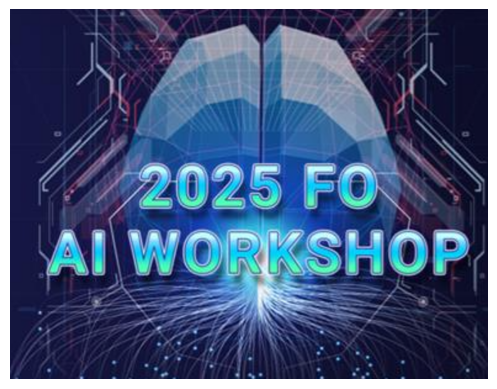

ID: 8
Score: 0.85510063
Content: '本次微軟展示的內容包含了以下幾種最新的AI應用 # M365 Copilot 應用示範 – Outlook：同時撰寫中文、英文與日文信件 – Teams：會議前、中、後快速查找所需資訊 – Word：撰寫商業提案 – PowerPoint：設計簡報並自動調整主題 – Excel：以自然語言生成報表、圖表與 Python 程式碼 # 工安 AI 偵測：利用輕量級語言模型 Phi 偵測工廠跌倒與火災並即時通報 # Power BI AI 報表：使用生產線示例資料，演示 Copilot 自然語言生成洞見、互動探索與行動版摘要 # AI Avatar 虛擬導覽：整合 Azure OpenAI Service 與 Speech Service，讓多語言 AI 替身協助台積電同仁帶領國際客戶參觀展場'
Image file: microsoft.png

image_url:  https://paytonavatarimage.blob.core.windows.net/tsmc-images/microsoft.png


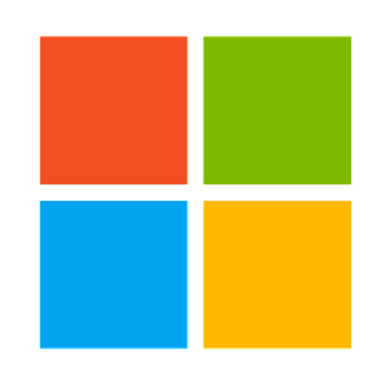

ID: 1
Score: 0.8543808
Content: '達明機器人股份有限公司成立於2015年，是全球唯一來自台灣的協作機器人品牌與製造商. 2022年推出下一代協作機器人TM AI Cobot. 公司透過遍及中國、歐洲、美洲、日本、南韓與東南亞的經銷網絡提供協作型機器人、智慧工廠管理軟體與應用解決方案. 機器手臂內建AI視覺功能，整合影像分類、物件偵測、影像分割與異物偵測四大技術，無需額外外掛系統. 可依應用場景訓練專屬模型，執行散熱片刮傷檢測、螺絲異物檢測與零件缺失檢測. 支援飛拍與輸送帶追蹤技術，在輸送過程中同步拍照，30秒內完成最多36項檢測. AI外觀檢測克服人眼檢查主觀性高與效率低的限制. 透過深度學習技術辨識表面瑕疵、色差與裂紋等多種缺陷. TMImage Manager為AI與智慧工廠現代化的基礎設施. 未來將在品質控管與生產效率提升中發揮關鍵作用. '
Image file: dm.png

image_url:  https://paytonavatarimage.blob.core.windows.net/tsmc-images/dm.png


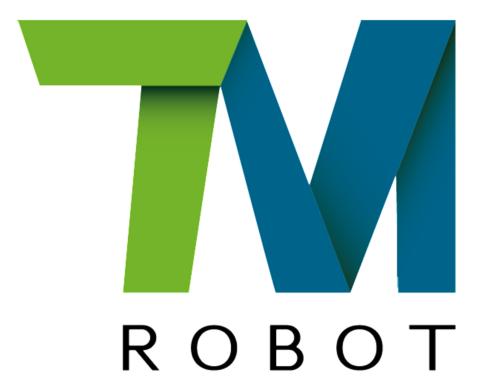

In [45]:
# Test code for using BlobServiceClient
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from PIL import Image

def display_image_from_blob(image_file):
    # Use public blob storage URL to display image
    image_url = (
        "https://paytonavatarimage.blob.core.windows.net/tsmc-images/" + image_file
    )
    print("image_url: ", image_url)
    response = requests.get(image_url)
    blob_data = response.content

    img = plt.imread(BytesIO(blob_data))
    plt.imshow(img)
    plt.axis('off')  # No axes for this plot
    plt.show()

def print_results(results):
  print("Results:")
  print(results)
  for result in results:
    print(f"ID: {result['id']}")
    print(f"Score: {result['@search.score']}")
    print(f"Content: {result['content']}")  
    print(f"Image file: {result['product_image_file']}\n")
    display_image_from_blob(result['product_image_file'])

# Pure Vector Search
#query = "請介紹今日的活動"
#query = "請介紹Teams 即時口譯"
#query = "請問Copilot議題, 有哪些議程?"

#query = "請用50個字介紹光寶科技
#query = "Hãy giới thiệu LITE-ON Technology trong 50 từ"
# query = "請介紹達明機器人"
# query = "達明機器人的機器手臂內建了哪四項AI視覺功能?"
# query = "請介紹所羅門科技"
# query = "AI智慧巡檢方案中，機器狗最遠可即時辨識多遠以外的設備?"
# query = "請介紹科林研發"
# query = "科林研發的半導體元件應用在哪些裝置上?"
# query = "微軟的核心產品包括哪些主要項目?"
# query = "本次微軟展出內容包括了哪些最新的AI應用"
# query = "M365 Copilot 應用示範有哪些?"
# query = "請介紹泰瑞達公司?"
# query = "請介紹2025 AI Workshop?"
# query = "2025 AI Workshop專家演講講者有哪些?"
query = "請問本次2025 AI Workshop, 包含哪些合作夥伴的廠商?"

results = search_client.search(  
    search_text=None,  
    vector=generate_embeddings(query), top_k=3,  
    vector_fields="content_vector",
    select= fields_of_interest
)
print_results(results)